In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import pickle
import os
import warnings

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2025-10-25 22:06:43.202786: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761430003.390394      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761430003.454800      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df_skin = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma', 
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

lesion_ID_dict = {
    'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 
    'akiec': 4, 'vasc': 5, 'df': 6
}

df_skin['lesion_type'] = df_skin['dx'].map(lesion_type_dict)
df_skin['lesion_ID'] = df_skin['dx'].map(lesion_ID_dict)

In [3]:
df_features = df_skin.copy()

missing_age = df_skin['age'].isnull().sum()
zero_age = (df_skin['age'] == 0).sum()

if missing_age > 0 or zero_age > 0:
    mean_ages_per_class = df_features[df_features['age'] > 0].groupby('dx')['age'].mean().round().astype(int)
    df_features['age'] = df_features.apply(
        lambda row: mean_ages_per_class[row['dx']] if pd.isna(row['age']) or row['age'] == 0 else row['age'],
        axis=1
    )

unknown_sex_count = (df_features['sex'] == 'unknown').sum()
if unknown_sex_count > 0:
    majority_sex_per_class = df_features[df_features['sex'] != 'unknown'].groupby('dx')['sex'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'unknown')
    df_features['sex'] = df_features.apply(
        lambda row: majority_sex_per_class[row['dx']] if row['sex'] == 'unknown' else row['sex'],
        axis=1
    )

unknown_localization_count = (df_features['localization'] == 'unknown').sum()
if unknown_localization_count > 0:
    majority_localization_per_class = df_features[df_features['localization'] != 'unknown'].groupby('dx')['localization'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'unknown')
    overall_majority = df_features[df_features['localization'] != 'unknown']['localization'].mode().iloc[0] if not df_features[df_features['localization'] != 'unknown']['localization'].mode().empty else 'trunk'
    df_features['localization'] = df_features.apply(
        lambda row: (majority_localization_per_class.get(row['dx'], overall_majority) 
                    if majority_localization_per_class.get(row['dx'], overall_majority) != 'unknown' 
                    else overall_majority) if row['localization'] == 'unknown' else row['localization'],
        axis=1
    )

sex_encoded = pd.get_dummies(df_features['sex'], prefix='sex')
df_features = pd.concat([df_features, sex_encoded], axis=1)

localization_encoded = pd.get_dummies(df_features['localization'], prefix='localization')
df_features = pd.concat([df_features, localization_encoded], axis=1)

sun_exposure_mapping = {
    'face': 1.0, 'neck': 0.9, 'ear': 0.9, 'scalp': 0.8, 'hand': 0.8,
    'upper extremity': 0.7, 'lower extremity': 0.6, 'chest': 0.5,
    'back': 0.4, 'foot': 0.4, 'trunk': 0.3, 'abdomen': 0.2,
    'acral': 0.3, 'genital': 0.01
}

df_features['sun_exposure_score'] = df_features['localization'].map(sun_exposure_mapping)
df_features['age_exposure_interaction'] = df_features['age'] * df_features['sun_exposure_score']

tabular_features = df_features[['lesion_id', 'image_id', 'lesion_ID'] + 
                              [col for col in df_features.columns if col.startswith(('sex_', 'localization_'))] +
                              ['age', 'sun_exposure_score', 'age_exposure_interaction']].copy()

In [4]:
X_train = np.load('/kaggle/input/hybridvfl-exp-1/X_train.npy')
X_test = np.load('/kaggle/input/hybridvfl-exp-1/X_test.npy')
y_train = np.load('/kaggle/input/hybridvfl-exp-1/y_train.npy')
y_test = np.load('/kaggle/input/hybridvfl-exp-1/y_test.npy')
y = np.load('/kaggle/input/hybridvfl-exp-1/y_augmented.npy')

with open('/kaggle/input/hybridvfl-exp-1/class_weight_dict.pkl', 'rb') as f:
    class_weight_dict = pickle.load(f)

In [5]:
image_model = load_model('/kaggle/input/hybridvfl-exp-1/best_image_model.keras')

feature_layer_name = 'max_pooling2d_2'
feature_layer = None
for layer in image_model.layers:
    if 'max_pooling2d' in layer.name and layer.name == feature_layer_name:
        feature_layer = layer
        break

if feature_layer is None:
    for layer in reversed(image_model.layers):
        if isinstance(layer, tf.keras.layers.MaxPool2D):
            feature_layer = layer
            feature_layer_name = layer.name
            break

if hasattr(image_model, 'input') and image_model.input is not None:
    model_input = image_model.input
else:
    model_input = image_model.layers[0].input

image_feature_extractor = Model(
    inputs=model_input,
    outputs=feature_layer.output
)

image_feature_extractor.trainable = False

train_image_features = image_feature_extractor.predict(X_train, verbose=0)
test_image_features = image_feature_extractor.predict(X_test, verbose=0)

train_image_features = train_image_features.reshape(train_image_features.shape[0], -1)
test_image_features = test_image_features.reshape(test_image_features.shape[0], -1)

I0000 00:00:1761430020.396412      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1761430025.697681      58 service.cc:148] XLA service 0x7cc7140035b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761430025.698193      58 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1761430025.804463      58 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1761430026.913834      58 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [6]:
def create_augmentation_mapping():
    image_id_mapping = []
    y_mapping = []
    
    image_dirs = ['/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/', 
                  '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/']
    
    for img_dir in image_dirs:
        if not os.path.exists(img_dir):
            continue
            
        file_list = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
        
        for filename in file_list:
            image_id = filename.replace('.jpg', '')
            lesion_data = df_skin[df_skin['image_id'] == image_id]
            
            if len(lesion_data) == 0:
                continue
                
            lesion_id = lesion_data['lesion_ID'].iloc[0]
            
            if lesion_id == 0:
                num_augmented = 1
            else:
                num_augmented = 6
            
            for _ in range(num_augmented):
                image_id_mapping.append(image_id)
                y_mapping.append(lesion_id)
    
    return np.array(image_id_mapping), np.array(y_mapping)

image_id_array, y_check = create_augmentation_mapping()

_, _, train_image_ids, test_image_ids = train_test_split(
    image_id_array, image_id_array,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

numerical_columns = ['age', 'sun_exposure_score', 'age_exposure_interaction'] + \
                   [col for col in tabular_features.columns if col.startswith(('sex_', 'localization_'))]

train_tabular_list = []
for img_id in train_image_ids:
    row = tabular_features[tabular_features['image_id'] == img_id][numerical_columns]
    if len(row) > 0:
        train_tabular_list.append(row.values[0])
    else:
        train_tabular_list.append(np.zeros(len(numerical_columns)))

train_tabular_features = np.array(train_tabular_list)

test_tabular_list = []
for img_id in test_image_ids:
    row = tabular_features[tabular_features['image_id'] == img_id][numerical_columns]
    if len(row) > 0:
        test_tabular_list.append(row.values[0])
    else:
        test_tabular_list.append(np.zeros(len(numerical_columns)))

test_tabular_features = np.array(test_tabular_list)

scaler = StandardScaler()
train_tabular_features = scaler.fit_transform(train_tabular_features)
test_tabular_features = scaler.transform(test_tabular_features)

In [7]:
image_input = Input(shape=(train_image_features.shape[1],), name='image_input')
tabular_input = Input(shape=(train_tabular_features.shape[1],), name='tabular_input')

image_proj = Dense(512, activation='relu', name='image_proj')(image_input)
image_proj = Dropout(0.3, name='image_dropout')(image_proj)

tabular_branch = Dense(128, activation='relu', name='tabular_dense1')(tabular_input)
tabular_branch = Dropout(0.3, name='tabular_dropout1')(tabular_branch)
tabular_branch = Dense(64, activation='relu', name='tabular_dense2')(tabular_branch)
tabular_branch = Dropout(0.2, name='tabular_dropout2')(tabular_branch)

common_dim = 128
image_common = Dense(common_dim, activation='relu', name='image_common')(image_proj)
tabular_common = Dense(common_dim, activation='relu', name='tabular_common')(tabular_branch)

interaction = tf.keras.layers.Multiply(name='cross_modal_interaction')([image_common, tabular_common])

direct_fusion = Concatenate(name='direct_fusion')([image_proj, tabular_branch])
interaction_fusion = Concatenate(name='interaction_fusion')([image_common, tabular_common, interaction])

final_features = Concatenate(name='final_fusion')([direct_fusion, interaction_fusion])

x = Dense(2048, activation='relu', name='fc1')(final_features)
x = Dropout(0.5, name='dropout1')(x)
x = Dense(1024, activation='relu', name='fc2')(x)
x = Dropout(0.4, name='dropout2')(x)
x = Dense(512, activation='relu', name='fc3')(x)
x = Dropout(0.3, name='dropout3')(x)
output = Dense(7, activation='softmax', name='output')(x)

multimodal_model = Model(inputs=[image_input, tabular_input], outputs=output, name='MultimodalModel')

multimodal_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [8]:
multimodal_callbacks = [
    ModelCheckpoint(
        '/kaggle/working/best_multimodal_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=0
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=0
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=0
    )
]

MULTIMODAL_EPOCHS = 50
MULTIMODAL_BATCH_SIZE = 32

history_multimodal = multimodal_model.fit(
    [train_image_features, train_tabular_features],
    y_train,
    validation_data=([test_image_features, test_tabular_features], y_test),
    epochs=MULTIMODAL_EPOCHS,
    batch_size=MULTIMODAL_BATCH_SIZE,
    callbacks=multimodal_callbacks,
    class_weight=class_weight_dict,
    verbose=0
)

# Print training summary
print("Training Progress:")
for epoch in range(len(history_multimodal.history['loss'])):
    train_loss = history_multimodal.history['loss'][epoch]
    train_acc = history_multimodal.history['accuracy'][epoch]
    val_loss = history_multimodal.history['val_loss'][epoch]
    val_acc = history_multimodal.history['val_accuracy'][epoch]
    print(f"Epoch {epoch+1}/{MULTIMODAL_EPOCHS} - loss: {train_loss:.4f} - acc: {train_acc:.4f} - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}")

Training Progress:
Epoch 1/50 - loss: 0.9637 - acc: 0.5789 - val_loss: 0.7520 - val_acc: 0.7149
Epoch 2/50 - loss: 0.5247 - acc: 0.7256 - val_loss: 0.6346 - val_acc: 0.7583
Epoch 3/50 - loss: 0.4098 - acc: 0.7745 - val_loss: 0.5811 - val_acc: 0.7811
Epoch 4/50 - loss: 0.3597 - acc: 0.8003 - val_loss: 0.5548 - val_acc: 0.7922
Epoch 5/50 - loss: 0.3184 - acc: 0.8169 - val_loss: 0.5218 - val_acc: 0.7984
Epoch 6/50 - loss: 0.2813 - acc: 0.8373 - val_loss: 0.5046 - val_acc: 0.8095
Epoch 7/50 - loss: 0.2526 - acc: 0.8455 - val_loss: 0.4993 - val_acc: 0.8197
Epoch 8/50 - loss: 0.2410 - acc: 0.8568 - val_loss: 0.4586 - val_acc: 0.8282
Epoch 9/50 - loss: 0.2206 - acc: 0.8679 - val_loss: 0.4725 - val_acc: 0.8295
Epoch 10/50 - loss: 0.1979 - acc: 0.8771 - val_loss: 0.4740 - val_acc: 0.8315
Epoch 11/50 - loss: 0.1861 - acc: 0.8855 - val_loss: 0.4377 - val_acc: 0.8468
Epoch 12/50 - loss: 0.1758 - acc: 0.8891 - val_loss: 0.4308 - val_acc: 0.8492
Epoch 13/50 - loss: 0.1607 - acc: 0.9015 - val_loss: 0

In [9]:
best_multimodal_model = load_model('/kaggle/working/best_multimodal_model.keras')

y_pred_mm = best_multimodal_model.predict([test_image_features, test_tabular_features], verbose=0)
y_pred_classes_mm = np.argmax(y_pred_mm, axis=1)
y_true_classes_mm = np.argmax(y_test, axis=1)

test_accuracy_mm = accuracy_score(y_true_classes_mm, y_pred_classes_mm)
balanced_acc_mm = balanced_accuracy_score(y_true_classes_mm, y_pred_classes_mm)
macro_f1_mm = f1_score(y_true_classes_mm, y_pred_classes_mm, average='macro')
macro_precision_mm = precision_score(y_true_classes_mm, y_pred_classes_mm, average='macro')
macro_recall_mm = recall_score(y_true_classes_mm, y_pred_classes_mm, average='macro')

print(f"Test Accuracy: {test_accuracy_mm:.4f}")
print(f"Balanced Accuracy: {balanced_acc_mm:.4f}")
print(f"Macro F1: {macro_f1_mm:.4f}")
print(f"Macro Precision: {macro_precision_mm:.4f}")
print(f"Macro Recall: {macro_recall_mm:.4f}")

Test Accuracy: 0.9100
Balanced Accuracy: 0.9325
Macro F1: 0.9222
Macro Precision: 0.9130
Macro Recall: 0.9325


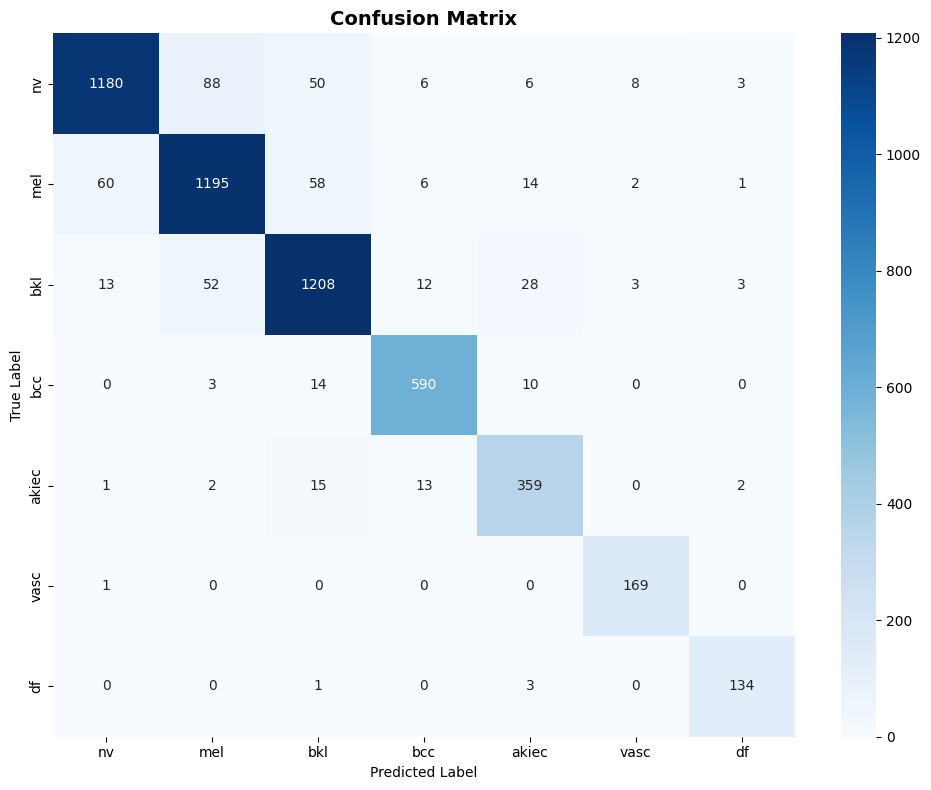

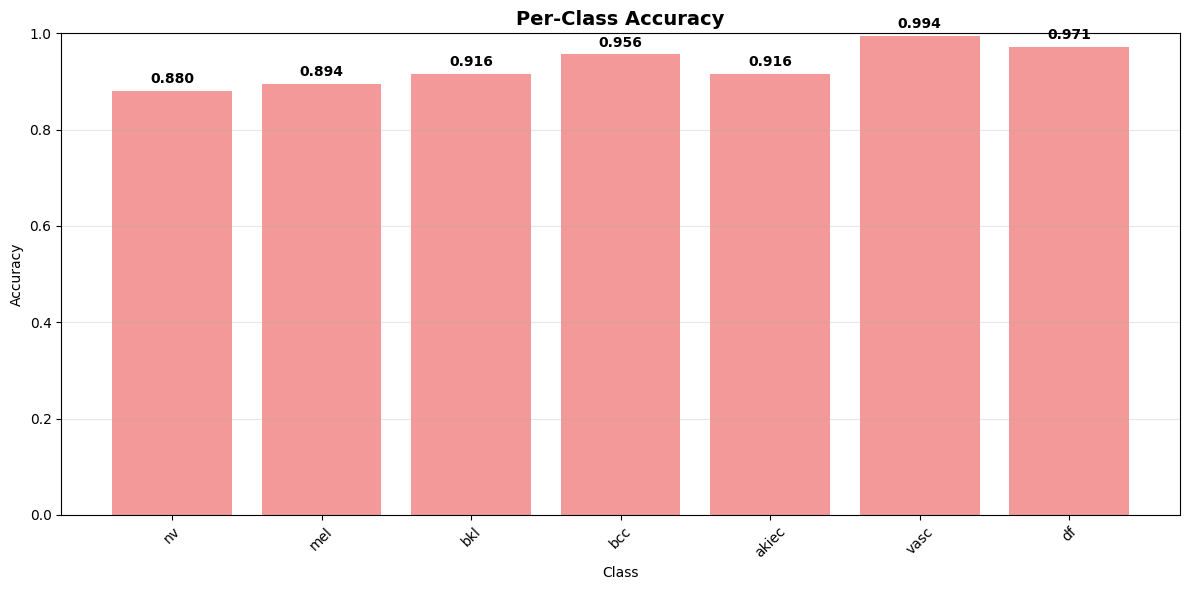

In [10]:
lesion_names_short = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

cm_mm = confusion_matrix(y_true_classes_mm, y_pred_classes_mm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_mm, annot=True, fmt='d', cmap='Blues',
            xticklabels=lesion_names_short,
            yticklabels=lesion_names_short)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

class_accuracies_mm = []
for i in range(7):
    class_mask = y_true_classes_mm == i
    if np.sum(class_mask) > 0:
        class_acc = np.mean(y_pred_classes_mm[class_mask] == y_true_classes_mm[class_mask])
        class_accuracies_mm.append(class_acc)
    else:
        class_accuracies_mm.append(0.0)

plt.figure(figsize=(12, 6))
bars = plt.bar(range(7), class_accuracies_mm, color='lightcoral', alpha=0.8)
plt.title('Per-Class Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.xticks(range(7), lesion_names_short, rotation=45)
plt.ylim(0, 1)

for i, (bar, acc) in enumerate(zip(bars, class_accuracies_mm)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
np.save('/kaggle/working/train_tabular_features.npy', train_tabular_features)
np.save('/kaggle/working/test_tabular_features.npy', test_tabular_features)

with open('/kaggle/working/tabular_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('/kaggle/input/hybridvfl-exp-1/exp1_results.pkl', 'rb') as f:
    exp1_results = pickle.load(f)

exp1_2_results = {
    'exp1_balanced_acc': exp1_results['balanced_accuracy'],
    'exp2_balanced_acc': float(balanced_acc_mm),
    'exp1_test_acc': exp1_results['test_accuracy'],
    'exp2_test_acc': float(test_accuracy_mm),
    'improvement': float((balanced_acc_mm - exp1_results['balanced_accuracy']) * 100)
}

with open('/kaggle/working/exp1_2_results.pkl', 'wb') as f:
    pickle.dump(exp1_2_results, f)

exp2_results = {
    'test_accuracy': float(test_accuracy_mm),
    'balanced_accuracy': float(balanced_acc_mm),
    'confusion_matrix': cm_mm,
    'training_history': {
        'loss': history_multimodal.history['loss'],
        'val_loss': history_multimodal.history['val_loss'],
        'acc': history_multimodal.history['accuracy'],
        'val_acc': history_multimodal.history['val_accuracy']
    },
    'predictions': y_pred_classes_mm
}

with open('/kaggle/working/exp2_results.pkl', 'wb') as f:
    pickle.dump(exp2_results, f)